In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import seisbench.data as sbd
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score
import time

In [25]:
# Device Checking
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [26]:
# Loading the dataset
dataset = sbd.STEAD()

# Label Encoding simple
label_map = {"noise": 0, "earthquake_local": 1}
dataset.metadata["label"] = dataset.metadata["trace_category"].map(label_map)

# Spliting the dataset
train_indices = dataset.metadata[dataset.metadata["split"] == "train"].index
dev_indices = dataset.metadata[dataset.metadata["split"] == "dev"].index

# 20% sanity mode (Using 20% of the dataset only)
train_indices = train_indices[:int(0.2 * len(train_indices))]

print("Training samples:", len(train_indices))
print("Validation samples:", len(dev_indices))

2026-03-01 11:58:20,884 | seisbench | WARNING | Output component order not specified, defaulting to 'ZNE'.


Training samples: 215161
Validation samples: 63283


In [27]:
class SteadTorchDataset(Dataset):
    def __init__(self, dataset, indices, crop_len=3000):
        self.dataset = dataset
        self.indices = indices
        self.crop_len = crop_len

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        wf = self.dataset.get_waveforms([real_idx])[0]

        # Crop for speed
        wf = wf[:, :self.crop_len]

        # Normalize
        wf = wf - wf.mean(axis=1, keepdims=True)
        wf = wf / (wf.std(axis=1, keepdims=True) + 1e-6)

        label = self.dataset.metadata.iloc[real_idx]["label"]

        return torch.tensor(wf, dtype=torch.float32), \
               torch.tensor(label, dtype=torch.float32)


train_dataset = SteadTorchDataset(dataset, train_indices)
dev_dataset = SteadTorchDataset(dataset, dev_indices)

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2,
                          pin_memory=True)

dev_loader = DataLoader(dev_dataset,
                        batch_size=16,
                        shuffle=False,
                        num_workers=2,
                        pin_memory=True)

In [28]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=0, dilation=dilation)

    def forward(self, x):
        x = F.pad(x, (self.padding, 0))
        return self.conv(x)

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size, dilation):
        super().__init__()
        self.conv1 = CausalConv1d(channels, channels, kernel_size, dilation)
        self.norm1 = nn.GroupNorm(1, channels)
        self.conv2 = CausalConv1d(channels, channels, kernel_size, dilation)
        self.norm2 = nn.GroupNorm(1, channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        residual = x
        out = self.relu(self.norm1(self.conv1(x)))
        out = self.dropout(self.norm2(self.conv2(out)))
        out += residual
        return self.relu(out)

In [30]:
class ResidualCausalTCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_conv = nn.Conv1d(3, 32, kernel_size=1)

        dilations = [1,2,4,8,16,32,64,128]  # 8 blocks

        self.blocks = nn.Sequential(
            *[ResidualBlock(32, 5, d) for d in dilations]
        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.input_conv(x)
        x = self.blocks(x)
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


model = ResidualCausalTCN().to(device)

In [31]:
labels = dataset.metadata.loc[train_indices]["label"].values
weights = compute_class_weight("balanced",
                               classes=np.unique(labels),
                               y=labels)

pos_weight = torch.tensor([weights[0] / weights[1]]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


In [32]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=1e-4,
                              weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
# scaler = torch.amp.GradScaler(device_type='cuda')

In [33]:
scaler = torch.cuda.amp.GradScaler()

def train_one_epoch():
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.unsqueeze(1).to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(x)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate():
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in dev_loader:
            x = x.to(device)
            y = y.unsqueeze(1).to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(y.cpu().numpy().flatten())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    return total_loss / len(dev_loader), precision, recall

/tmp/ipykernel_8038/1242697417.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [34]:
num_epochs = 10

for epoch in range(num_epochs):
    start = time.time()

    train_loss = train_one_epoch()
    val_loss, precision, recall = evaluate()
    scheduler.step()

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Epoch Time: {time.time() - start:.2f} sec")
    print("-"*40)


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1
Train Loss: 0.0362
Val Loss: 0.0261
Precision: 0.9995
Recall: 0.9684
Epoch Time: 461.44 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2
Train Loss: 0.0146
Val Loss: 0.0277
Precision: 0.9998
Recall: 0.9613
Epoch Time: 511.45 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3
Train Loss: 0.0116
Val Loss: 0.0186
Precision: 0.9998
Recall: 0.9782
Epoch Time: 844.00 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4
Train Loss: 0.0081
Val Loss: 0.0161
Precision: 0.9998
Recall: 0.9803
Epoch Time: 653.12 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5
Train Loss: 0.0075
Val Loss: 0.0110
Precision: 0.9997
Recall: 0.9876
Epoch Time: 484.31 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6
Train Loss: 0.0062
Val Loss: 0.0153
Precision: 0.9996
Recall: 0.9851
Epoch Time: 473.79 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7
Train Loss: 0.0054
Val Loss: 0.0415
Precision: 1.0000
Recall: 0.9499
Epoch Time: 472.21 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8
Train Loss: 0.0051
Val Loss: 0.0086
Precision: 0.9999
Recall: 0.9900
Epoch Time: 457.53 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9
Train Loss: 0.0040
Val Loss: 0.0085
Precision: 0.9996
Recall: 0.9908
Epoch Time: 457.15 sec
----------------------------------------


/tmp/ipykernel_8038/1242697417.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10
Train Loss: 0.0038
Val Loss: 0.0112
Precision: 0.9998
Recall: 0.9877
Epoch Time: 456.01 sec
----------------------------------------


In [35]:
model.eval()
dummy = torch.randn(1,3,3000).to(device)

with torch.no_grad():
    start = time.time()
    for _ in range(100):
        _ = model(dummy)
    end = time.time()

print("Avg inference time per window:",
      (end-start)/100, "seconds")

Avg inference time per window: 0.0020026898384094237 seconds


In [36]:
torch.save(model.state_dict(), "final_model.pth")
print("✅ Final model saved.")

✅ Final model saved.


In [37]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "epoch": 9
}, "checkpoint_epoch9.pth")

print("✅ Full checkpoint saved.")

✅ Full checkpoint saved.


In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in dev_loader:
        x = x.to(device)
        outputs = model(x)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_probs.extend(probs.flatten())
        all_labels.extend(y.numpy().flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

In [39]:
roc_auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

print("ROC AUC:", roc_auc)

ROC AUC: 0.9995659000998356


In [40]:
pr_auc = average_precision_score(all_labels, all_probs)
precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)

print("PR AUC:", pr_auc)

PR AUC: 0.9999057037870355


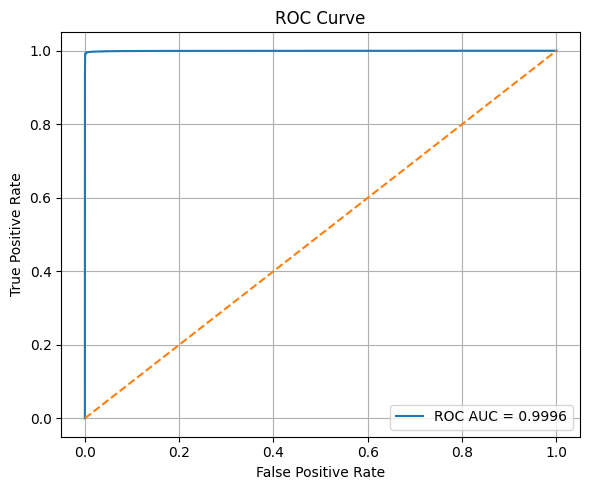

In [41]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300)
plt.show()

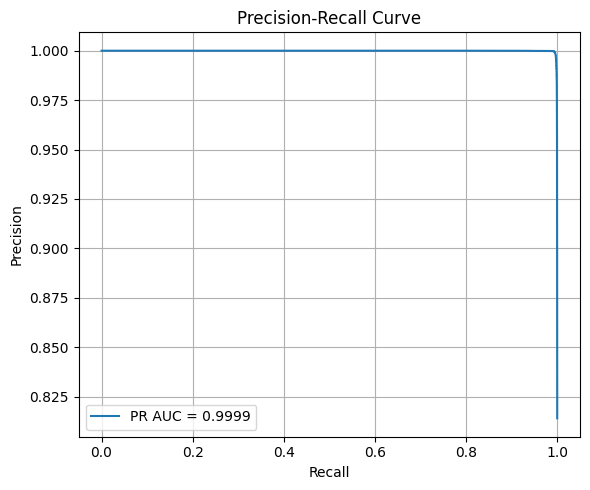

In [42]:
plt.figure(figsize=(6,5))
plt.plot(recall_curve, precision_curve, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pr_curve.png", dpi=300)
plt.show()
